# Symptom-Based Disease Prediction System

## Description

The **Symptom-Based Disease Prediction System** is a machine learning-powered application designed to assist in the early identification of diseases based on user-reported symptoms. The system uses a dataset of diseases and their associated symptoms along with severity weights to build a predictive model. Users can input their symptoms, and the model predicts the most likely diseases along with confidence scores.

### Key Features:

- **Symptom Input:** Users provide a list of symptoms they are experiencing.
- **Severity-Based Prediction:** Symptoms are weighted according to their clinical severity to improve prediction accuracy.
- **Top Disease Predictions:** The system returns the top three most probable diseases with confidence percentages.
- **Visualization:** Confusion matrix and other evaluation metrics help understand model performance.
- **Reusable Model:** The trained model and encoders can be saved and loaded for future predictions without retraining.
- **Machine Learning Backend:** Uses a Random Forest classifier to handle multi-class disease prediction efficiently.



In [154]:
import joblib

In [155]:
!pip install opendatasets

# 1. Download the dataset

In [156]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/itachi9604/disease-symptom-description-dataset'
od.download(dataset_url)

Skipping, found downloaded files in "./disease-symptom-description-dataset" (use force=True to force download)


# 2. Import libraries and Load dataset
- Import required libraries

- Load and shuffle the dataset

- Normalize and clean text data

- Handle missing values

- Load symptom severity information

- Create a symptom-to-severity mapping

In [157]:
# ===============================
#  IMPORTS
# ===============================
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# ===============================
#  LOAD DATASET
# ===============================
df = pd.read_csv('/content/disease-symptom-description-dataset/dataset.csv')

# Shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Original dataset:\n {df.head()}")
print(f"Dataset size: {df.shape}")
print("\n")

empty_rows = df.isna().all(axis=1).sum()
print(f"number of empty rows = {empty_rows}")
print("\n")

# Normalize text
for col in df.columns:
    df[col] = (
        df[col]
        .astype(str)
        .str.strip()
        .str.lower()
        .str.replace('_', ' ')
    )

df = df.replace('nan', np.nan)

print(f"Disease list:\n {df['Disease'].unique()}")
print("\n")

severity_df = pd.read_csv(
    "/content/disease-symptom-description-dataset/Symptom-severity.csv"
)

print(f"Symptoms list:\n {severity_df['Symptom'].unique()}")
print("\n")

print(f"number of diseases: {df['Disease'].nunique()}")
print(f"number of symptoms: {severity_df['Symptom'].nunique()}")
print("\n")

print(f"Normalized dataset:\n {df.head()}")
print("\n")

severity_df['Symptom'] = (
    severity_df['Symptom']
    .str.lower()
    .str.strip()
    .str.replace('_', ' ')
)

severity_map = dict(
    zip(severity_df['Symptom'], severity_df['weight'])
)

print(f"symptom-to-severity mapping:\n {severity_map}")

Original dataset:
                Disease        Symptom_1            Symptom_2        Symptom_3  \
0                 Acne        skin_rash           blackheads         scurring   
1                 Acne        skin_rash   pus_filled_pimples       blackheads   
2      Hyperthyroidism          fatigue          mood_swings      weight_loss   
3                 AIDS   muscle_wasting    patches_in_throat       high_fever   
4  Chronic cholestasis          itching             vomiting   yellowish_skin   

                 Symptom_4          Symptom_5        Symptom_6  \
0                      NaN                NaN              NaN   
1                 scurring                NaN              NaN   
2             restlessness           sweating        diarrhoea   
3   extra_marital_contacts                NaN              NaN   
4                   nausea   loss_of_appetite   abdominal_pain   

            Symptom_7          Symptom_8         Symptom_9     Symptom_10  \
0                 Na

In [158]:
df.describe()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
count,4920,4920,4920,4920,4572,3714,2934,2268,1944,1692,1512,1194,744,504,306,240,192,72
unique,41,34,48,54,50,38,32,26,21,22,21,18,11,8,4,3,3,1
top,acne,vomiting,vomiting,fatigue,high fever,headache,nausea,abdominal pain,abdominal pain,yellowing of eyes,yellowing of eyes,irritability,malaise,stomach bleeding,chest pain,chest pain,loss of smell,muscle pain
freq,120,822,870,726,378,348,390,264,276,228,198,120,126,72,96,144,72,72


# 3. Extract All Unique Symptoms

This section of the code identifies and indexes all unique symptoms present in the dataset.  
The resulting symptom list is later used for feature encoding in the disease prediction model.


In [159]:
symptom_columns = df.columns[1:]

all_symptoms = set()
for col in symptom_columns:
    all_symptoms.update(df[col].dropna())

all_symptoms = sorted(all_symptoms)
print("Total symptoms:", len(all_symptoms))
print("\n")

symptom_index = {symptom: idx for idx, symptom in enumerate(all_symptoms)}
symptom_index


Total symptoms: 131




{'abdominal pain': 0,
 'abnormal menstruation': 1,
 'acidity': 2,
 'acute liver failure': 3,
 'altered sensorium': 4,
 'anxiety': 5,
 'back pain': 6,
 'belly pain': 7,
 'blackheads': 8,
 'bladder discomfort': 9,
 'blister': 10,
 'blood in sputum': 11,
 'bloody stool': 12,
 'blurred and distorted vision': 13,
 'breathlessness': 14,
 'brittle nails': 15,
 'bruising': 16,
 'burning micturition': 17,
 'chest pain': 18,
 'chills': 19,
 'cold hands and feets': 20,
 'coma': 21,
 'congestion': 22,
 'constipation': 23,
 'continuous feel of urine': 24,
 'continuous sneezing': 25,
 'cough': 26,
 'cramps': 27,
 'dark urine': 28,
 'dehydration': 29,
 'depression': 30,
 'diarrhoea': 31,
 'dischromic  patches': 32,
 'distention of abdomen': 33,
 'dizziness': 34,
 'drying and tingling lips': 35,
 'enlarged thyroid': 36,
 'excessive hunger': 37,
 'extra marital contacts': 38,
 'family history': 39,
 'fast heart rate': 40,
 'fatigue': 41,
 'fluid overload': 42,
 'foul smell of urine': 43,
 'headache': 4

# 4. Create a Multi-Hot Encoded Feature Matrix

This section converts symptom data into a numerical feature matrix that can be used as input for the machine learning model.  
Each row represents a patient (or record), and each column represents a unique symptom.
Each symptom is assigned with a weight which represents its severity level.


In [160]:
X = np.zeros((len(df), len(all_symptoms)))

for i, row in df.iterrows():
    for col in symptom_columns:
        symptom = row[col]
        if pd.notna(symptom):
            weight = severity_map.get(symptom, 1)  # fallback = 1
            X[i, symptom_index[symptom]] = weight

pd.DataFrame(X)


,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4916,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4917,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 5. Encode Disease Labels

This section converts disease names (categorical labels) into numerical form so they can be used as target values for machine learning model training.
For example:
flu → 0,
migraine → 1,
diabetes → 2


In [161]:
le = LabelEncoder()
y = le.fit_transform(df['Disease'])

print("Total diseases:", len(le.classes_))
le.classes_

Total diseases: 41


array(['(vertigo) paroymsal  positional vertigo', 'acne', 'aids',
       'alcoholic hepatitis', 'allergy', 'arthritis', 'bronchial asthma',
       'cervical spondylosis', 'chicken pox', 'chronic cholestasis',
       'common cold', 'dengue', 'diabetes',
       'dimorphic hemmorhoids(piles)', 'drug reaction',
       'fungal infection', 'gastroenteritis', 'gerd', 'heart attack',
       'hepatitis a', 'hepatitis b', 'hepatitis c', 'hepatitis d',
       'hepatitis e', 'hypertension', 'hyperthyroidism', 'hypoglycemia',
       'hypothyroidism', 'impetigo', 'jaundice', 'malaria', 'migraine',
       'osteoarthristis', 'paralysis (brain hemorrhage)',
       'peptic ulcer diseae', 'pneumonia', 'psoriasis', 'tuberculosis',
       'typhoid', 'urinary tract infection', 'varicose veins'],
      dtype=object)

# 6. Train–Test Split Using Stratified Sampling

This section splits the dataset into training and testing sets.  
Stratified splitting ensures that each disease appears proportionally in training and testing set.


In [162]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=42
)

train_idx, test_idx = next(sss.split(X, y))

x_train, x_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print(f"train size: {len(x_train)}")
print(f"test size: {len(x_test)}")

print("\n")

count_df = pd.DataFrame({
    "Disease": le.inverse_transform(range(0,41)),
    "Full Dataset": pd.Series(y).value_counts(),
    "Training Set": pd.Series(y_train).value_counts(),
    "Test Set": pd.Series(y_test).value_counts()
}).fillna(0)

count_df



train size: 3936
test size: 984




,Disease,Full Dataset,Training Set,Test Set
0,(vertigo) paroymsal positional vertigo,120,96,24
1,acne,120,96,24
2,aids,120,96,24
3,alcoholic hepatitis,120,96,24
4,allergy,120,96,24
5,arthritis,120,96,24
6,bronchial asthma,120,96,24
7,cervical spondylosis,120,96,24
8,chicken pox,120,96,24
9,chronic cholestasis,120,96,24


# 7. Train the Random Forest Model

This section trains a Random Forest classifier on the encoded symptom data and evaluates its performance on the test dataset. The Random Forest model is configured with the following parameters:

- n_estimators = 100
Number of decision trees in the forest. More trees generally improve stability.

- max_depth = 5
Limits the depth of each tree to prevent overfitting.

- min_samples_leaf = 3
Ensures that each leaf node has at least 3 samples, improving generalization.

- random_state = 42
Ensures reproducible training results.

- n_jobs = -1
Utilizes all available CPU cores for faster training.

In [163]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)

model.fit(x_train, y_train)

preds = model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, preds) * 100)


Accuracy: 98.8821138211382


# 8. Confusion Matrix Visualization

This section evaluates the performance of the trained disease prediction model by visualizing the confusion matrix.  
The confusion matrix provides a detailed breakdown of correct and incorrect predictions for each disease class.



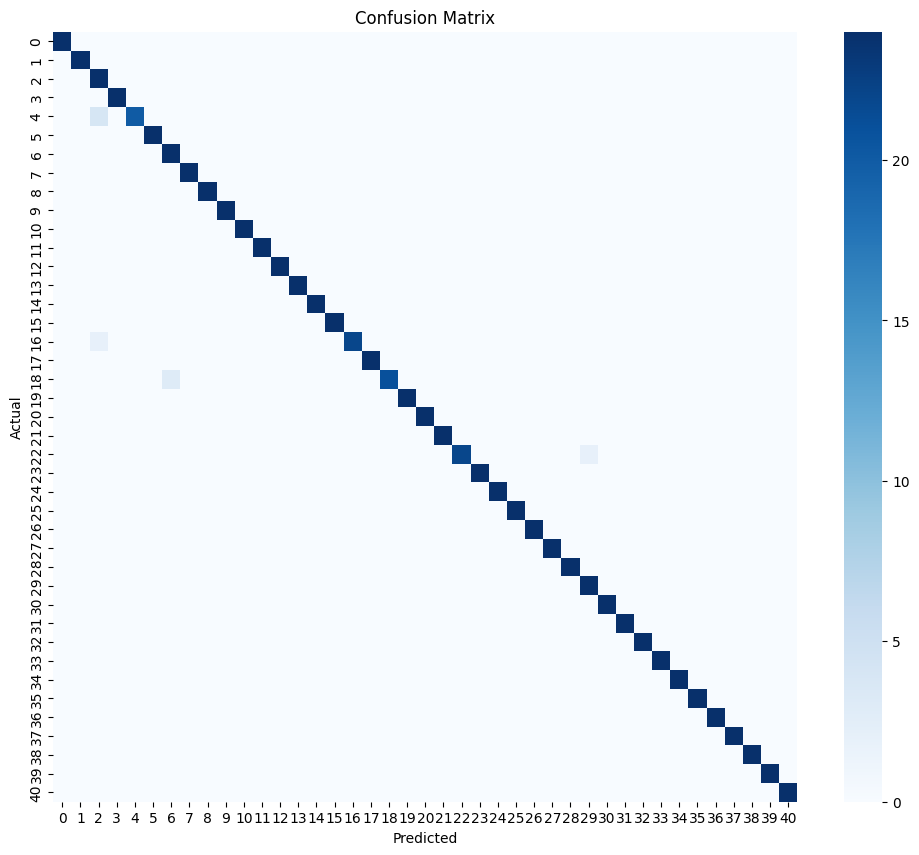

In [164]:
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# 9. Save the Trained Model and Encoders

This section saves the trained machine learning model and the associated encoders so that they can be reused later for prediction without retraining.



In [165]:
joblib.dump(model, "model.joblib")
joblib.dump(symptom_index, "symptom_index.joblib")
joblib.dump(le, "label_encoder.joblib")

print("Model and encoders saved.")


Model and encoders saved.


# 10. Load Saved Components and Define Disease Prediction Function

This section loads the saved model and encoders and defines a function to predict diseases based on a given list of symptoms.
This is how `predict_disease` function works:
![predict disease flowchart](predict_disease_flowchart.svg)


In [166]:
loaded_model = joblib.load("model.joblib")
loaded_symptom_index = joblib.load("symptom_index.joblib")
loaded_le = joblib.load("label_encoder.joblib")

def predict_disease(symptoms):
    x = np.zeros(len(loaded_symptom_index))

    for s in symptoms:
        s = s.lower().strip().replace('_', ' ')
        if s in loaded_symptom_index:
            weight = severity_map.get(s, 1)
            x[loaded_symptom_index[s]] = weight

    probs = loaded_model.predict_proba([x])[0]
    top = np.argsort(probs)[-3:][::-1]

    top_probs = probs[top]
    normalized = top_probs / top_probs.sum()

    results = []
    for idx, p in zip(top, normalized):
        results.append({
            "disease": loaded_le.inverse_transform([idx])[0],
            "confidence": round(p * 100, 2)
        })

    return results



# 11. Example Disease Prediction

This section demonstrates how to use the `predict_disease` function to generate disease predictions from a list of input symptoms. This function returns 3 most probable diseases along with their confidence levels based on input symptoms.


In [167]:
predict_disease([
    'irregular sugar level',
    'weight loss',
    'increased appetite'
])

[{'disease': 'diabetes', 'confidence': np.float64(80.46)},
 {'disease': 'aids', 'confidence': np.float64(9.86)},
 {'disease': 'allergy', 'confidence': np.float64(9.68)}]